In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report
from sklearn.impute import SimpleImputer
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import log_loss, accuracy_score

import plotly.graph_objects as go
import numpy as np


In [2]:
weighted_df = pd.read_csv("data/weighted_pop_ipc_region.csv") # Read generalized data by weighted population into DataFrame
weighted_df.set_index(["datetime", "district"], inplace=True) # Set index

In [3]:
density_df = pd.read_csv("data/density_pop_ipc_region.csv") # Read generalized data by density population into DataFrame
density_df.set_index(["datetime", "district"], inplace=True) # Set index

# Defined functions given to us at the start of the project

In [4]:
# The function create_laf_df is used to add lagged columns to data to prepare it for the model
def create_lag_df(df, columns, lag, difference=False, rolling=None, dropna=False):
    '''
    Function to add lagged colums to dataframe
    
    Inputs:
        df - Dataframe
        columns - List of columns to create lags from
        lag - The number of timesteps (in months for the default data) to lag the variable by
        difference - Whether to take the difference between each observation as new column
        rolling - The size of the rolling mean window, input None type to not use a rolling variable
        dropna - Whether to drop NaN values
        
    Output:
        df - Dataframe with the lagged columns added
    '''
    
    for column in columns:
        col = df[column].unstack()
        if rolling:
            col = col.rolling(rolling).mean()
        if difference:
            col = col.diff()
        if dropna:
            col = col.dropna(how='any')
        df[f"{column}_lag_{lag}"] = col.shift(lag).stack()
    return df



In [5]:
# The function plot_ConfusionMatrix is used for the predicted values from the model and true values to create confusion matrices as heatmaps
def plot_ConfusionMatrix(prediction, true, binary=False):
    '''
    Function to plot a confusion matrix as a heatmap from a prediction and true values.
    
    Inputs:
        prediction - The predicted values
        true - the true values
        binary - whether the variable is binary or not
        
    Output:
        confusion_matrix - The calculated confusion matrix based on the prediction and true values.
        
        Also plots the confusion matrix as heatmap in an interactive environment such as Jupyter Notebook.
    '''
    
    y_pred = prediction
    
    if not binary:
        # Round prediction to nearest integer (i.e. the nearest phase)
        y_pred = y_pred.round() 
        y_pred = np.minimum(y_pred, 5) # Cap maximum prediction at 5 (maximum phase)
        y_pred = np.maximum(y_pred, 1) # Cap minimum prediction at 1 (minimum phase)

    # Initialize confusion matrix
    confusion_matrix = pd.crosstab(
        true, y_pred, rownames=["Actual"], colnames=["Predicted"]
    )

    # Plot confusion matrix as heatmap
    sns.heatmap(confusion_matrix, annot=True, fmt="g")
    plt.show()
    plt.clf()
    
    return confusion_matrix

In [6]:
# Creating lagged columns on the weighted mean population data for count_violence, food_price_idx, ipc
# For IPC will have been created 1-month lag, 2-month lag, 3-month lag
weighted_df = create_lag_df(weighted_df, ['count_violence', 'ndvi_anom'], 3, rolling=6) # 3-month-lagged rolling mean window of size 6
weighted_df = create_lag_df(weighted_df, ['food_price_idx'], 3, difference=True, rolling=6) # difference of the 3-month-lagged rolling mean window of size 6
weighted_df = create_lag_df(weighted_df, ['ipc'], 1, dropna=True) # 1-month-lag
weighted_df = create_lag_df(weighted_df, ['ipc'], 2, dropna=True) # 2-month-lag
weighted_df = create_lag_df(weighted_df, ['ipc'], 3, dropna=True) # 3-month-lag

# After the lagged columns have been added, the data is indexed by date
weighted_df.reset_index(inplace=True)
weighted_df.set_index('datetime', inplace=True)
weighted_df.sort_index(level=0, inplace=True)
weighted_df.index = pd.to_datetime(weighted_df.index) # Makes sure the index has a datetime format
weighted_df # Print the weighted mean population data

,district,country,district_code,centx,centy,year_month,year,month,ipc,ha,...,total_region_pop,normalized_population,weighted_ipc_pop,generalized_ipc_pop,count_violence_lag_3,ndvi_anom_lag_3,food_price_idx_lag_3,ipc_lag_1,ipc_lag_2,ipc_lag_3
datetime,,,,,,,,,,,,,,,,,,,,,
2009-07-01,Bor,South Sudan,74,32.00486,6.465644,2009_07,2009,7,2.0,NaN,...,3394056.00,0.075608,0.151216,1.902810,NaN,NaN,NaN,NaN,NaN,NaN
2009-07-01,Terekeka,South Sudan,97,31.32576,5.662623,2009_07,2009,7,1.0,NaN,...,3284728.00,0.051538,0.051538,1.386920,NaN,NaN,NaN,NaN,NaN,NaN
2009-07-01,Duk,South Sudan,116,31.18647,7.617574,2009_07,2009,7,2.0,NaN,...,3394056.00,0.022458,0.044916,1.902810,NaN,NaN,NaN,NaN,NaN,NaN
2009-07-01,Tonj East,South Sudan,117,29.28494,7.847276,2009_07,2009,7,1.0,NaN,...,3036461.00,0.043199,0.043199,1.897398,NaN,NaN,NaN,NaN,NaN,NaN
2009-07-01,Fashoda,South Sudan,147,31.84424,9.980295,2009_07,2009,7,1.0,NaN,...,3394056.00,0.012878,0.012878,1.902810,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-01,Koch,South Sudan,127,29.85742,8.633903,2020_02,2020,2,3.0,0.0,...,3860036.43,0.027077,0.081232,3.397920,0.166667,111.294617,2.234340,3.0,3.0,3.0
2020-02-01,Aweil Center,South Sudan,128,26.89562,8.417934,2020_02,2020,2,3.0,1.0,...,2666084.46,0.013140,0.039421,3.013384,0.000000,105.971917,3.064545,3.0,3.0,3.0
2020-02-01,Gogrial East,South Sudan,129,28.58906,8.597443,2020_02,2020,2,3.0,0.0,...,2666084.46,0.038477,0.115430,3.013384,0.166667,106.954817,2.734335,3.0,2.0,2.0


In [7]:
# Creating lagged columns on the density population data for count_violence, food_price_idx, ipc
# For IPC will have been created 1-month lag, 2-month lag, 3-month lag
density_df = create_lag_df(density_df, ['count_violence', 'ndvi_anom'], 3, rolling=6) # 3-month-lagged rolling mean window of size 6
density_df = create_lag_df(density_df, ['food_price_idx'], 3, difference=True, rolling=6) # difference of the 3-month-lagged rolling mean window of size 6
density_df = create_lag_df(density_df, ['ipc'], 1, dropna=True) # 1-month-lag
density_df = create_lag_df(density_df, ['ipc'], 2, dropna=True) # 2-month-lag
density_df = create_lag_df(density_df, ['ipc'], 3, dropna=True) # 3-month-lag

# After the lagged columns have been added, the data is indexed by date
density_df.reset_index(inplace=True)
density_df.set_index('datetime', inplace=True)
density_df.sort_index(level=0, inplace=True)
density_df.index = pd.to_datetime(density_df.index) # Makes sure the index has a datetime format
density_df # Print the density population data

,district,country,district_code,centx,centy,year_month,year,month,ipc,ha,...,generalized_ipc_pop,pop_density,weighted_ipc_density,generalized_ipc_density,count_violence_lag_3,ndvi_anom_lag_3,food_price_idx_lag_3,ipc_lag_1,ipc_lag_2,ipc_lag_3
datetime,,,,,,,,,,,,,,,,,,,,,
2009-07-01,Bor,South Sudan,74,32.00486,6.465644,2009_07,2009,7,2.0,NaN,...,1.902810,1.831896e+07,3.663791e+07,1.840095,NaN,NaN,NaN,NaN,NaN,NaN
2009-07-01,Terekeka,South Sudan,97,31.32576,5.662623,2009_07,2009,7,1.0,NaN,...,1.386920,1.579304e+07,1.579304e+07,1.403153,NaN,NaN,NaN,NaN,NaN,NaN
2009-07-01,Duk,South Sudan,116,31.18647,7.617574,2009_07,2009,7,2.0,NaN,...,1.902810,1.107115e+07,2.214229e+07,1.840095,NaN,NaN,NaN,NaN,NaN,NaN
2009-07-01,Tonj East,South Sudan,117,29.28494,7.847276,2009_07,2009,7,1.0,NaN,...,1.897398,2.954181e+07,2.954181e+07,1.935449,NaN,NaN,NaN,NaN,NaN,NaN
2009-07-01,Fashoda,South Sudan,147,31.84424,9.980295,2009_07,2009,7,1.0,NaN,...,1.902810,1.210934e+07,1.210934e+07,1.840095,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-01,Koch,South Sudan,127,29.85742,8.633903,2020_02,2020,2,3.0,0.0,...,3.397920,2.360382e+07,7.081147e+07,3.511564,0.166667,111.294617,2.234340,3.0,3.0,3.0
2020-02-01,Aweil Center,South Sudan,128,26.89562,8.417934,2020_02,2020,2,3.0,1.0,...,3.013384,3.127129e+06,9.381387e+06,3.047154,0.000000,105.971917,3.064545,3.0,3.0,3.0
2020-02-01,Gogrial East,South Sudan,129,28.58906,8.597443,2020_02,2020,2,3.0,0.0,...,3.013384,2.308662e+07,6.925985e+07,3.047154,0.166667,106.954817,2.734335,3.0,2.0,2.0


In [8]:
news_df = pd.read_csv("data/articles_topics_extra_topics.csv") # Read news data into DataFrame

# Create date column
news_df["datetime"] = pd.to_datetime(
    pd.to_datetime(news_df["date"], format="%Y-%m-%d").dt.strftime("%Y-%m"),
    format="%Y-%m",
)

In [9]:
# The function create_news_features was also provided at the start of the project
# It is used to turn the True/False values of the categories for each article into numerical values, so they can be used on the predictive model
def create_news_features(columns):
    cols = []
    for column in columns:
        col = news_df.groupby(["datetime"])[column].mean()
        col = col.fillna(0)
        col = col.rolling(3).mean()
        col = col.shift(3)
        cols.append(col)
    return pd.concat(cols, axis=1)

# The selected categories are the same ones as the ones from Topic Modelling: hunger, refugees, conflict, humanitarian, corruption, terrorism, nature, oil, livestock
news_features = create_news_features(
    ["hunger", 'refugees', 'conflict', 'humanitarian', 'corruption', 'terrorism', 'nature', 'oil', 'livestock'])

news_features.index = pd.to_datetime(news_features.index) # Makes sure that the index of the news features data has the datetime format

news_features # Print the news features data

,hunger,refugees,conflict,humanitarian,corruption,terrorism,nature,oil,livestock
datetime,,,,,,,,,
2011-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2022-12-01,0.022222,4.625929e-18,9.251859e-18,4.444444e-02,0.000000,0.022222,0.022222,0.027778,0.000000
2023-01-01,0.022222,4.625929e-18,9.251859e-18,4.444444e-02,0.027778,0.022222,0.077778,0.027778,0.000000
2023-02-01,0.083333,4.625929e-18,9.251859e-18,9.251859e-18,0.027778,0.000000,0.138889,0.027778,0.083333


In [10]:
weighted_df.sort_index(level=0, inplace=True) # Sort the weighted population data by date
# Merge the weighted population data with the news features data, to obtain a full dataset for the predictive model
weighted_df = weighted_df.merge(news_features, left_index=True, right_index=True, how='left')
weighted_df.drop(['province'], axis=1, inplace=True) # Remove the column 'province' from the merged dataset
weighted_df

,district,country,district_code,centx,centy,year_month,year,month,ipc,ha,...,ipc_lag_3,hunger,refugees,conflict,humanitarian,corruption,terrorism,nature,oil,livestock
datetime,,,,,,,,,,,,,,,,,,,,,
2009-07-01,Bor,South Sudan,74,32.00486,6.465644,2009_07,2009,7,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-07-01,Mundri East,South Sudan,92,30.68256,5.307882,2009_07,2009,7,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-07-01,Nyirol,South Sudan,130,32.11970,8.583063,2009_07,2009,7,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-07-01,Aweil East,South Sudan,141,27.61364,9.243139,2009_07,2009,7,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-07-01,Yei,South Sudan,81,30.34454,4.252148,2009_07,2009,7,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-01,Jur River,South Sudan,75,28.02439,7.592506,2020_02,2020,2,2.0,0.0,...,3.0,0.0,4.625929e-18,9.251859e-18,0.010753,0.062379,0.0,0.022052,0.050144,0.0
2020-02-01,Bor,South Sudan,74,32.00486,6.465644,2020_02,2020,2,3.0,0.0,...,3.0,0.0,4.625929e-18,9.251859e-18,0.010753,0.062379,0.0,0.022052,0.050144,0.0
2020-02-01,Juba,South Sudan,90,31.48342,4.717081,2020_02,2020,2,3.0,0.0,...,3.0,0.0,4.625929e-18,9.251859e-18,0.010753,0.062379,0.0,0.022052,0.050144,0.0


In [11]:
density_df.sort_index(level=0, inplace=True) # Sort density population dataset by date
# Merge the density population data with the news features data, to obtain a full dataset for the predictive model
density_df = density_df.merge(news_features, left_index=True, right_index=True, how='left')
density_df.drop(['province'], axis=1, inplace=True) # Remove the column 'province' from the merged dataset
density_df

,district,country,district_code,centx,centy,year_month,year,month,ipc,ha,...,ipc_lag_3,hunger,refugees,conflict,humanitarian,corruption,terrorism,nature,oil,livestock
datetime,,,,,,,,,,,,,,,,,,,,,
2009-07-01,Bor,South Sudan,74,32.00486,6.465644,2009_07,2009,7,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-07-01,Mundri East,South Sudan,92,30.68256,5.307882,2009_07,2009,7,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-07-01,Nyirol,South Sudan,130,32.11970,8.583063,2009_07,2009,7,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-07-01,Aweil East,South Sudan,141,27.61364,9.243139,2009_07,2009,7,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-07-01,Yei,South Sudan,81,30.34454,4.252148,2009_07,2009,7,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-01,Jur River,South Sudan,75,28.02439,7.592506,2020_02,2020,2,2.0,0.0,...,3.0,0.0,4.625929e-18,9.251859e-18,0.010753,0.062379,0.0,0.022052,0.050144,0.0
2020-02-01,Bor,South Sudan,74,32.00486,6.465644,2020_02,2020,2,3.0,0.0,...,3.0,0.0,4.625929e-18,9.251859e-18,0.010753,0.062379,0.0,0.022052,0.050144,0.0
2020-02-01,Juba,South Sudan,90,31.48342,4.717081,2020_02,2020,2,3.0,0.0,...,3.0,0.0,4.625929e-18,9.251859e-18,0.010753,0.062379,0.0,0.022052,0.050144,0.0


# PREDICTING WITH BINARY MODEL - Weightead Mean Population Data

/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:1050: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:1055: RuntimeWarning: invalid value encountered in true_divide
  T = new_sum / new_sample_count
/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:1075: RuntimeWarning: invalid value encountered in true_divide
  new_unnormalized_variance -= correction**2 / new_sample_count
/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/impute/_base.py:558: UserWarning: Skipping features without any observed values: [ 5  6  7  8  9 10 11 12 13]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.1

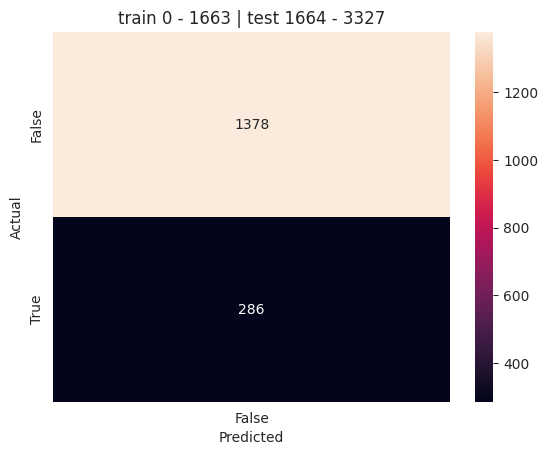

/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

              precision    recall  f1-score   support

       False       0.83      1.00      0.91      1378
        True       0.00      0.00      0.00       286

    accuracy                           0.83      1664
   macro avg       0.41      0.50      0.45      1664
weighted avg       0.69      0.83      0.75      1664


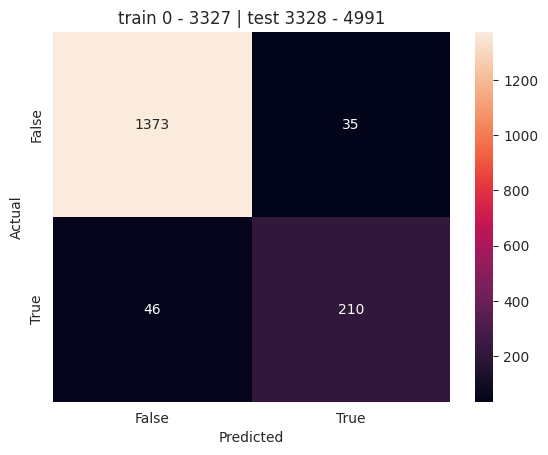

/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

       False       0.97      0.98      0.97      1408
        True       0.86      0.82      0.84       256

    accuracy                           0.95      1664
   macro avg       0.91      0.90      0.90      1664
weighted avg       0.95      0.95      0.95      1664


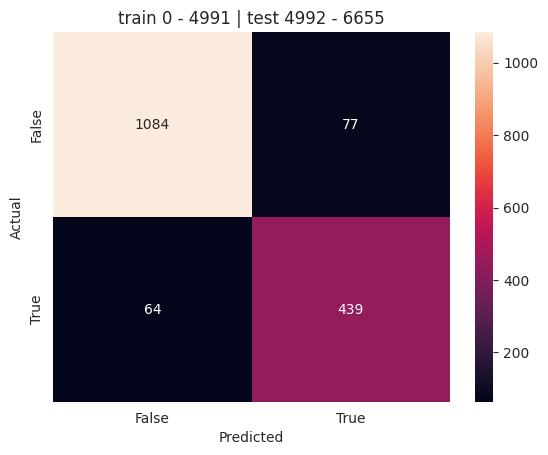

              precision    recall  f1-score   support

       False       0.94      0.93      0.94      1161
        True       0.85      0.87      0.86       503

    accuracy                           0.92      1664
   macro avg       0.90      0.90      0.90      1664
weighted avg       0.92      0.92      0.92      1664


/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


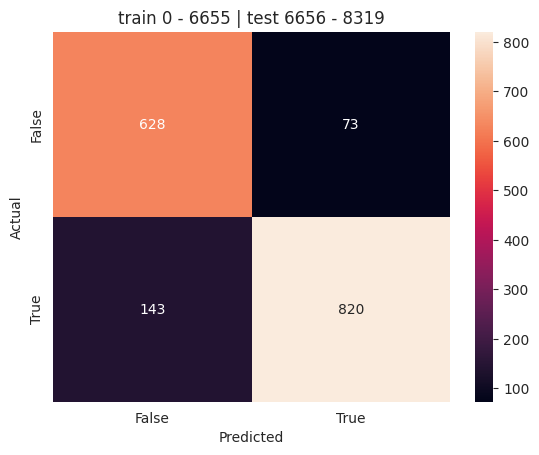

              precision    recall  f1-score   support

       False       0.81      0.90      0.85       701
        True       0.92      0.85      0.88       963

    accuracy                           0.87      1664
   macro avg       0.87      0.87      0.87      1664
weighted avg       0.87      0.87      0.87      1664


/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


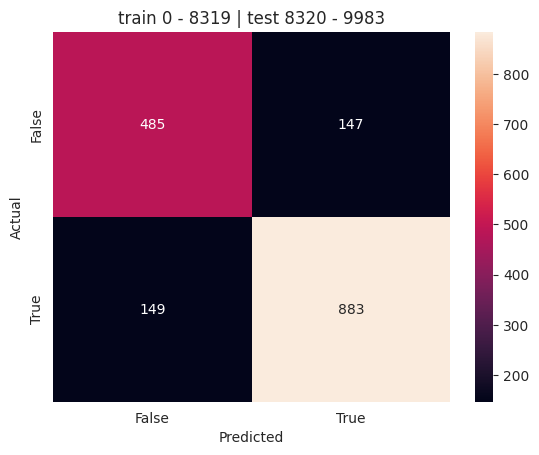

              precision    recall  f1-score   support

       False       0.76      0.77      0.77       632
        True       0.86      0.86      0.86      1032

    accuracy                           0.82      1664
   macro avg       0.81      0.81      0.81      1664
weighted avg       0.82      0.82      0.82      1664

Mean Accuracy: 0.877404
Accuracy of each set: [0.828125, 0.9513221153846154, 0.9152644230769231, 0.8701923076923077, 0.8221153846153846]


<Figure size 640x480 with 0 Axes>

In [12]:
# Define an imputer that uses mean in order to create more data points
imputer = SimpleImputer(strategy='mean') 

df_copy = weighted_df.copy()
df_copy.drop(['quarters', 'ha'], axis=1, inplace=True) # Remove unwanted columns
X = df_copy.iloc[:, -14:] # Define explanatory variables
y = df_copy[["ipc"]]  # Define target data
y = y.astype(int) #Make sure that the format of the target data is int

scaler = StandardScaler() #Define a scaler

cv = TimeSeriesSplit(n_splits=5) # Create the 5 splits using TimeSeriesSplit

# Initialize empty lists to store scores
accuracy_values = list()
train_loss_values_w = list()
val_loss_values_w = list()

for train_index, val_index in cv.split(X, y):  # Use X and y as inputs for splitting

    y_binary = y > 2.5 # Convert y to binary variable
    y_binary[y.isna()] = pd.NA # Conserve NaN values
    y_binary = y_binary.astype("float32") # Convert y to float

    # Creating the datasets X_train, X_test, y_train, and y_val from the indices obtain by the cv
    X_train, X_test = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y_binary.iloc[train_index], y_binary.iloc[val_index]
    # Scale X_train and X_test
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    # Impute more data points
    X_train = imputer.fit_transform(X_train)
    X_test = imputer.transform(X_test)
    
    # Define the model by using regularization (L1)
    model = LogisticRegression(C=0.01, max_iter=100, penalty='l1', random_state=42, solver='saga')
    model.fit(X_train, y_train) # Fit the model to the data
    y_pred = model.predict(X_test) # Predict whether there is going to be crisis or not
    
    y_pred = y_pred.round().astype(bool) # Round up and make sure it is a Boolean as it should be True or False
    y_val = y_val.round().astype(bool) # Round up and make sure it is a Boolean as it should be True or False
    
    y_pred = y_pred[list(y_val.isnull()['ipc']==False)] # Null values will be considered as False
    y_val.dropna(inplace=True) # Null values will be removed
    
    accuracy = accuracy_score(y_val, y_pred) # Calculate the accuracy score
    accuracy_values.append(accuracy) # Add it to the list
    train_loss = log_loss(y_train, model.predict_proba(X_train)[:, 1]) # Calculate the train loss
    val_loss = log_loss(y_val, model.predict_proba(X_test)[:, 1]) # Calculate the log loss

    train_loss_values_w.append(train_loss) # Add it to the list
    val_loss_values_w.append(val_loss) # Add it to the list

    plt.title('train %s - %s | test %s - %s' % (train_index[0], train_index[-1], val_index[0], val_index[-1])) # Create the title for the confusion matrix
    plot_ConfusionMatrix(prediction = y_pred, true = y_val['ipc'], binary = True) # Plot confusion matrix

    print (classification_report(y_val,y_pred)) # Print the classification report and the metrics calculated
    
print(f"Mean Accuracy: {np.mean(accuracy_values):.6f}") # Print Mean Accuracy
print(f"Accuracy of each set: {accuracy_values}") # Print accuracy of each set

### TEST OVERFITTING

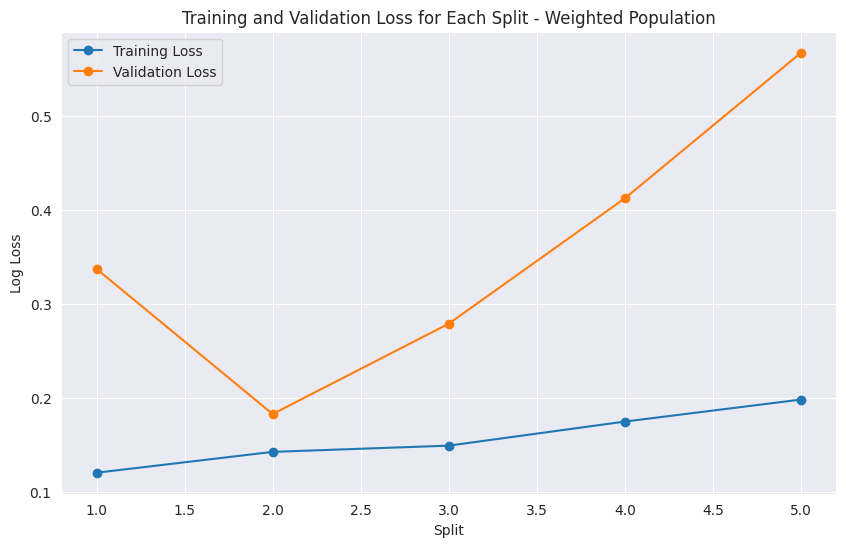

In [13]:
# After the loop, you can plot training and validation loss values for each split
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_loss_values_w) + 1), train_loss_values_w, marker='o', label='Training Loss')
plt.plot(range(1, len(val_loss_values_w) + 1), val_loss_values_w, marker='o', label='Validation Loss')
plt.xlabel('Split')
plt.ylabel('Log Loss')
plt.title('Training and Validation Loss for Each Split - Weighted Population')
plt.legend()
plt.grid(True)
plt.show()


# PREDICTING WITH BINARY MODEL - Density Population Data

/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:1050: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:1055: RuntimeWarning: invalid value encountered in true_divide
  T = new_sum / new_sample_count
/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:1075: RuntimeWarning: invalid value encountered in true_divide
  new_unnormalized_variance -= correction**2 / new_sample_count
/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/impute/_base.py:558: UserWarning: Skipping features without any observed values: [ 5  6  7  8  9 10 11 12 13]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.1

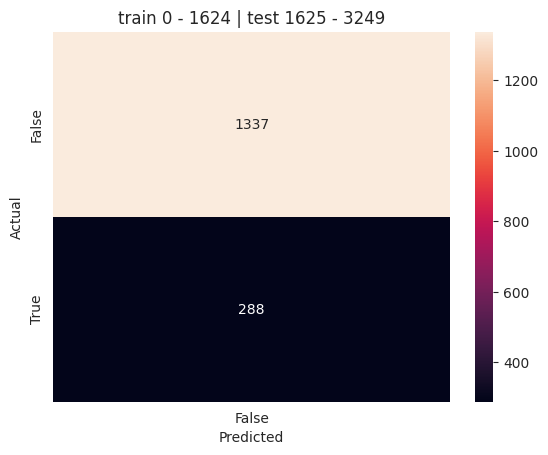

/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

              precision    recall  f1-score   support

       False       0.82      1.00      0.90      1337
        True       0.00      0.00      0.00       288

    accuracy                           0.82      1625
   macro avg       0.41      0.50      0.45      1625
weighted avg       0.68      0.82      0.74      1625


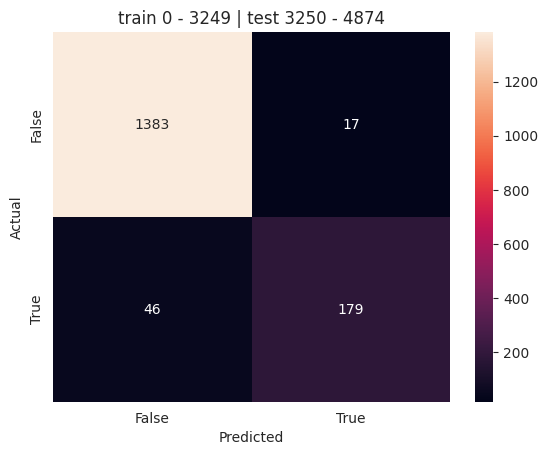

/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

       False       0.97      0.99      0.98      1400
        True       0.91      0.80      0.85       225

    accuracy                           0.96      1625
   macro avg       0.94      0.89      0.91      1625
weighted avg       0.96      0.96      0.96      1625


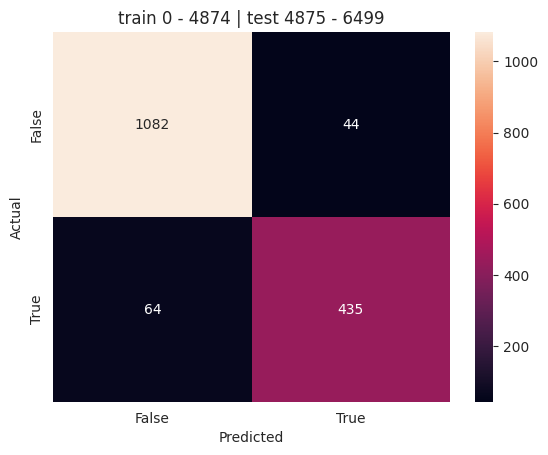

              precision    recall  f1-score   support

       False       0.94      0.96      0.95      1126
        True       0.91      0.87      0.89       499

    accuracy                           0.93      1625
   macro avg       0.93      0.92      0.92      1625
weighted avg       0.93      0.93      0.93      1625


/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


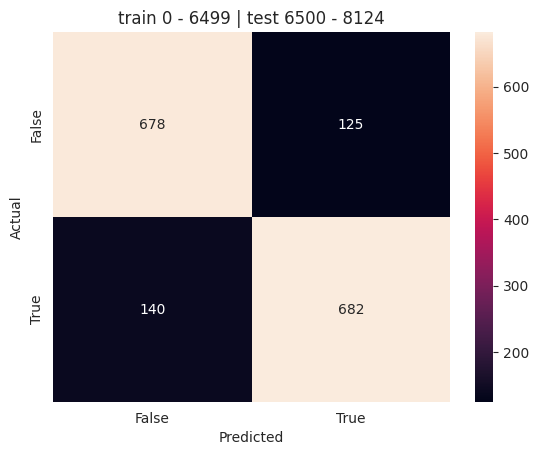

              precision    recall  f1-score   support

       False       0.83      0.84      0.84       803
        True       0.85      0.83      0.84       822

    accuracy                           0.84      1625
   macro avg       0.84      0.84      0.84      1625
weighted avg       0.84      0.84      0.84      1625


/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


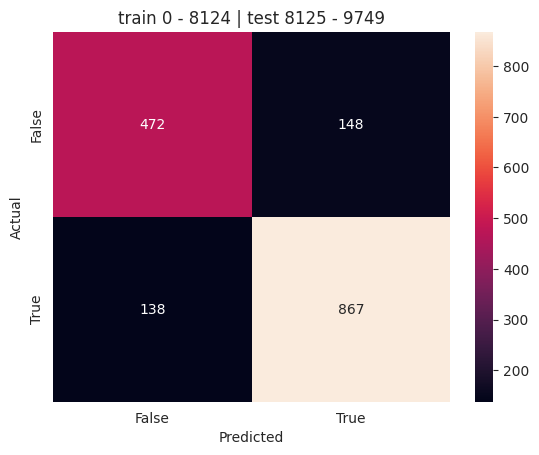

              precision    recall  f1-score   support

       False       0.77      0.76      0.77       620
        True       0.85      0.86      0.86      1005

    accuracy                           0.82      1625
   macro avg       0.81      0.81      0.81      1625
weighted avg       0.82      0.82      0.82      1625

Mean Accuracy: 0.875692
Accuracy of each set: [0.8227692307692308, 0.9612307692307692, 0.9335384615384615, 0.8369230769230769, 0.824]


<Figure size 640x480 with 0 Axes>

In [14]:

imputer = SimpleImputer(strategy='mean') 

df_copy = density_df.copy()
# Exclude Dec 2019 and Jan, Feb of 2020 as it will be used in a plot later on
exclude_df = df_copy.loc[((df_copy["year"] == 2020) & (df_copy["month"] >= 1)) | ((df_copy["year"] == 2019) & (df_copy["month"] == 12))]
df_copy = pd.concat([df_copy, exclude_df]).drop_duplicates(keep=False)
df_copy.drop(['quarters', 'ha'], axis=1, inplace=True)
X = df_copy.iloc[:, -14:] # Define explanatory variables
y = df_copy[["ipc"]]  # Define target data
y = y.astype(int)

scaler = StandardScaler()
# Use TimeSeriesSplit to split the data 5 times
cv = TimeSeriesSplit(n_splits=5)

# Initialize empty lists to store scores
accuracy_values = list()
train_loss_values_d = list()
val_loss_values_d = list()

model = LogisticRegression(C=0.01, max_iter=100, penalty='l1', random_state=42, solver='saga')

for train_index, val_index in cv.split(X, y):  # Use X and y as inputs for splitting

    y_binary = y > 2.5 # Convert y to binary variable
    y_binary[y.isna()] = pd.NA # Conserve NaN values
    y_binary = y_binary.astype("float32") # Convert y to float


    X_train, X_test = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y_binary.iloc[train_index], y_binary.iloc[val_index]
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    X_train = imputer.fit_transform(X_train)
    X_test = imputer.transform(X_test)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    y_pred = y_pred.round().astype(bool)
    y_val = y_val.round().astype(bool)
    
    y_pred = y_pred[list(y_val.isnull()['ipc']==False)]
    y_val.dropna(inplace=True)
    
    accuracy = accuracy_score(y_val, y_pred)
    accuracy_values.append(accuracy)
    train_loss = log_loss(y_train, model.predict_proba(X_train)[:, 1])
    val_loss = log_loss(y_val, model.predict_proba(X_test)[:, 1])

    train_loss_values_d.append(train_loss)
    val_loss_values_d.append(val_loss)

    plt.title('train %s - %s | test %s - %s' % (train_index[0], train_index[-1], val_index[0], val_index[-1]))
    plot_ConfusionMatrix(prediction = y_pred, true = y_val['ipc'], binary = True) # Plot confusion matrix

    print (classification_report(y_val,y_pred))
    
print(f"Mean Accuracy: {np.mean(accuracy_values):.6f}") # Print MAE
print(f"Accuracy of each set: {accuracy_values}")

### TEST OVERFITTING

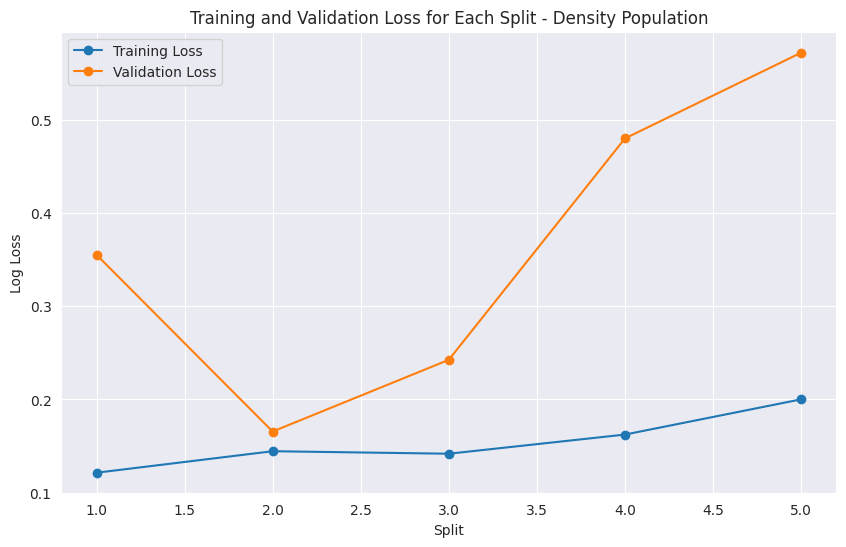

In [15]:
# After the loop, you can plot training and validation loss values for each split
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_loss_values_d) + 1), train_loss_values_d, marker='o', label='Training Loss')
plt.plot(range(1, len(val_loss_values_d) + 1), val_loss_values_d, marker='o', label='Validation Loss')
plt.xlabel('Split')
plt.ylabel('Log Loss')
plt.title('Training and Validation Loss for Each Split - Density Population')
plt.legend()
plt.grid(True)
plt.show()


# PLOT COUNT OF OCCURRENCES IN 2019 AND 2020 ON REAL VALUES VS PREDICTED

In [16]:
# From the excluded data generate a new dataframe to use as the model will predict the values for only that period of time
three_month_data = exclude_df.iloc[:, -14:]
three_month_data = scaler.fit_transform(three_month_data)
three_month_data = imputer.fit_transform(three_month_data)
three_month_target = exclude_df[["ipc"]]
three_month_target['crisis'] = three_month_target['ipc'] > 2.5
y_train_pred = model.predict(three_month_data)
rounded_y_train_pred = np.where(y_train_pred > 0.5, True, False)
# Get the unique values and their counts
unique_values, counts = np.unique(rounded_y_train_pred, return_counts=True)

# Print the results
for value, count in zip(unique_values, counts):
    print(f"{value} occurs {count} times")


# Get the unique values and their counts
unique_values, counts = np.unique(three_month_target['crisis'].values, return_counts=True)

# Print the results
for value, count in zip(unique_values, counts):
    print(f"{value} occurs {count} times")

False occurs 209 times
True occurs 25 times
False occurs 30 times
True occurs 204 times


/tmp/ipykernel_8393/4067538087.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  three_month_target['crisis'] = three_month_target['ipc'] > 2.5


In [20]:
# Create a dataframe with the predicted values
predicted_df = exclude_df
predicted_df['predicted'] = rounded_y_train_pred.tolist()
predicted_df['crisis'] = predicted_df['ipc'] > 2.5
# Count the number of occurrences of Crisis in both the predicted values and the real values
b = predicted_df[['year', 'crisis']].value_counts()
e = predicted_df[['year', "predicted"]].value_counts()
c = b.to_frame(name='count')
e = e.to_frame(name='count').reset_index()
d = c.reset_index()

# Assign colors for crisis=True and crisis=False
d['color'] = np.where(d['crisis'], 'red', 'blue')
e['color'] = np.where(e['predicted'], 'red', 'blue')

# Define the plot
plot = go.Figure()
plot.add_trace(go.Bar( #Adds for each year Crisis or No crisis for real values
    x=d["year"],
    y=d["count"],
    name='Crisis',
    marker_color=d['color'],  # Assign colors based on crisis status
    customdata=np.transpose([d['crisis'].tolist()]),
    hovertemplate="<br>".join([
        "Crisis?: %{customdata[0]}",
        "Count: %{y}"
    ])
))
plot.add_trace(go.Bar( # Adds for each year Crisis or No crisis for predicted values
    x=d["year"],
    y=e["count"],
    name='No Crisis',
    marker_color=e['color'],  # Assign colors based on crisis status
    customdata=np.transpose([e['predicted'].tolist()]),
    hovertemplate="<br>".join([
        "Crisis?: %{customdata[0]}",
        "Count: %{y}"
    ])
))

plot.update_layout( # Defines the layout of the plot
    title='3-month Future Prediction Performance Logistic Regression',
    width=600,
    height=500,
    yaxis=dict(
        title='Count of Occurrences',
        titlefont_size=16,
        tickfont_size=14,
    ),
    xaxis=dict(
        title='Year',
        titlefont_size=16,
        tickfont_size=14,
    ),
    legend=dict(
        x=0,
        y=1.0,
        bgcolor='rgba(255, 255, 255, 0)',
        bordercolor='rgba(255, 255, 255, 0)'
    ),
    barmode='group',
    bargap=0.3,  # gap between bars of adjacent location coordinates.
    bargroupgap=0.01  # gap between bars of the same location coordinate.
)

plot.show()


The first column of each year shows the real values and the second one shows the predicted values.